In [183]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import utils
import gpfunctions as gp
import lstm_model
import benchmarkfunctions as bm
import skopt


In [139]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [140]:
LOSS_FUNCS = ['MIN']
BASELINES = ['SKOPT', 'RANDOM']
DIMS = [2,3,4,6]
N_STEPS = 20

In [188]:
FUNCTIONS = {
    '2d': bm.goldstein_price,
    '2d_tf': bm.goldstein_price_tf,
    '3d': bm.hartmann3,
    '3d_tf': bm.hartmann3_tf,
    '4d': bm.styblinski4,
    '4d_tf': bm.styblinski4_tf,
    '6d': bm.hartmann6,
    '6d_tf': bm.hartmann6_tf,
    'name': {
        2: 'GoldStein Price',
        3: 'Hartmann3',
        4: 'Styblinski–Tang',
        6: 'Hartmann6'
    }
}

In [173]:
def get_y_from_skopt(dim, n_start_random=10, runs=10):
    obj_func =  lambda x : float(FUNCTIONS['%dd'%(dim)](x))
    data = []
    for i in range(runs):
        res = skopt.gp_minimize(obj_func, [(-1.0, 1.0)]*dim, n_calls=N_STEPS+1, x0=[-1]*dim)
        data.append(res.func_vals)
    return np.mean(np.array(data),axis=0)

def get_y_from_random(dim, steps, runs=10):
    data = []
    for i in range(runs):
        x = np.random.uniform(-1,1,(dim,steps))
        x[:, 0] = [-1]*dim
        y = np.apply_along_axis(FUNCTIONS['%dd'%(dim)], 0, x)
        data.append(y.T)
    return np.mean(np.array(data),axis=0)

In [143]:
def get_y_from_lstm(kernel, dim, loss, func, n_steps=20, debug=False):
    
    model = utils.get_trained_model(dim=dim, kernel=kernel, loss=loss)    
    starting_point = utils.loadConfig()['experiments']['%dD'%dim]['hyperparameters']['starting_point'][0]

    model_params = lstm_model.load_model_params(model, debug=False)

    res = None
    with tf.Session() as sess:

        lstm_params = {
            'dim' : model_params['dim'],
            'n_hidden': model_params['n_hidden'],
            'forget_bias': model_params['forget_bias'],
            'scope': model_params['scope']
        }
        cell, weights = lstm_model.get_lstm_weights(**lstm_params)
        
        saver = tf.train.Saver()
        saver.restore(sess, model_params['model_path'])

        benchmark_samples_params = {
            'f': func,
            'cell': cell,
            'weights': weights,
            'dim': model_params['dim'],
            'n_hidden': model_params['n_hidden'],
            'n_steps': model_params['n_steps'],
            'scope': model_params['scope'],
            'batch_size': 1
        }
        
        samples_benchmark_x, samples_benchmark_y, x_0 = lstm_model.apply_lstm_model(**benchmark_samples_params)
    
        feed_dict = {
            x_0: np.array(starting_point).reshape(1,-1)
        }
        sample_y, sample_x = sess.run([samples_benchmark_y, samples_benchmark_x], feed_dict=feed_dict)
        sample_y = np.array(sample_y).reshape(-1,1).T
        sample_x = np.array(sample_x).reshape(-1,1, model_params['dim']).transpose((1,0,2)).reshape(-1,model_params['dim'])
        return sample_y.T

In [197]:
def plot_for_dim(dim):
    data = {}
    data['SKOPT']  = utils.min_up_to_k(get_y_from_skopt(dim))
    data['RANDOM'] = utils.min_up_to_k(get_y_from_random(dim, steps = N_STEPS+1))
    
    for k in BASELINES:
        label = k
        if k is 'SKOPT':
            label = 'SKOPT-GP'
        plt.plot(data[k], label=label)
        
    for kernel in ['rbf', 'matern32']:
        for loss in LOSS_FUNCS:
            y = get_y_from_lstm(kernel, dim, loss, FUNCTIONS['%dd_tf'%(dim)])
            y = utils.min_up_to_k(y)
            plt.plot(y, label='LSTM-%s-%s'%(loss, kernel.upper()))
        
    xticks = range(0,N_STEPS+1,2)
    plt.ylabel('Min Found')
    plt.xlabel('Evaluation Step')
    plt.xticks(xticks)
    plt.ylim(-1)
    plt.title('%dD : %s' % (dim, FUNCTIONS['name'][dim]) )
    plt.plot()

/Users/heytitle/projects/neural-network-project/python3-env/lib/python3.5/site-packages/skopt/optimizer/optimizer.py:195: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


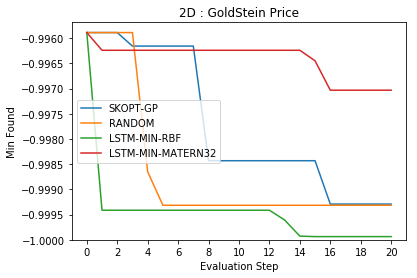

In [195]:
plot_for_dim(2)

/Users/heytitle/projects/neural-network-project/python3-env/lib/python3.5/site-packages/skopt/optimizer/optimizer.py:195: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


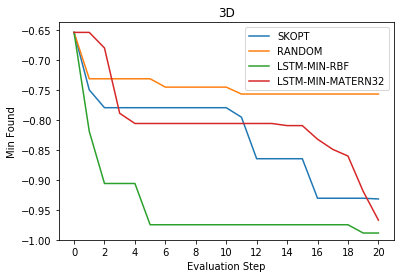

In [175]:
plot_for_dim(3)

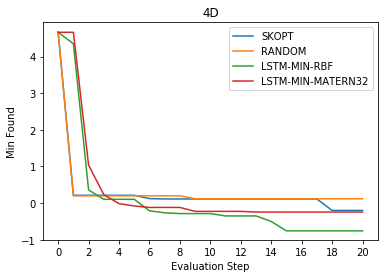

In [185]:
plot_for_dim(4)

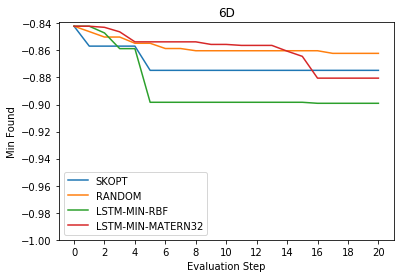

In [176]:
plot_for_dim(6)

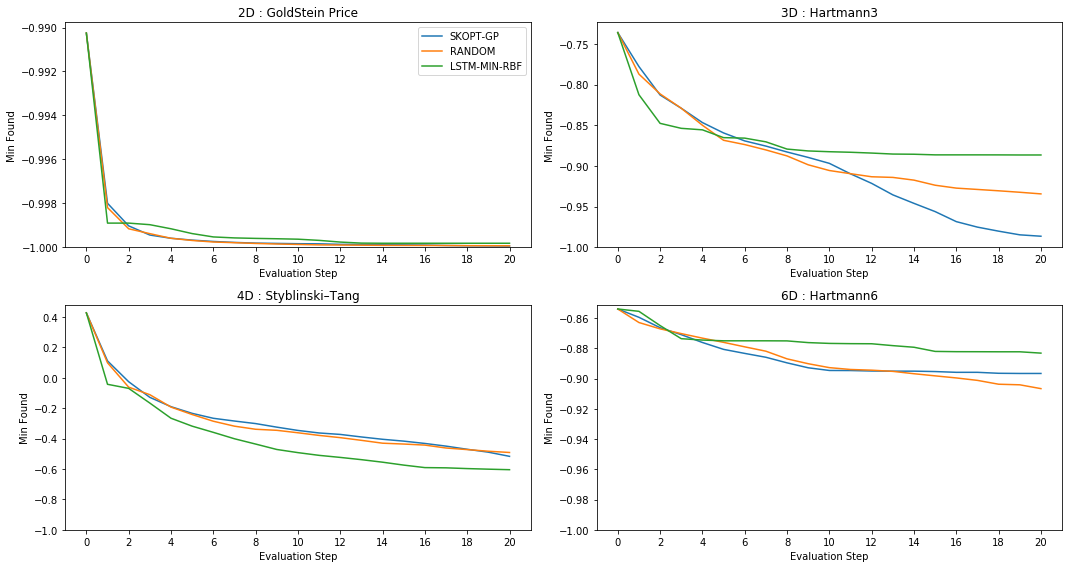

In [248]:
count = 0
plt.figure(figsize=(15,4*2))
for d in [2,3,4,6]:
    plt.subplot(2,2,count + 1 )

    plot_for_dim_new_version(d)
    if d is 2:
        plt.legend()
    count = count + 1
plt.tight_layout()

In [209]:
np.random.seed(100)
np.random.uniform(-1,1, (10,2))

array([[ 0.08680988, -0.44326123],
       [-0.15096482,  0.68955226],
       [-0.99056229, -0.75686176],
       [ 0.34149817,  0.65170551],
       [-0.72658682,  0.15018666],
       [ 0.78264391, -0.58159576],
       [-0.62934356, -0.78324622],
       [-0.56060501,  0.95724757],
       [ 0.6233663 , -0.65611797],
       [ 0.6324495 , -0.45185251]])

In [210]:
print("sdf %s" %([1,2]))

sdf [1, 2]


In [212]:
gp_2d_y = np.load('./benchmark-result/skopt_gp.npy')

In [213]:
print(gp_2d_y)

[[-0.99947602 -0.90801261 -0.97499542 -0.99903845 -0.980214   -0.99513247
  -0.99783228 -0.98073826 -0.99697398 -0.99693319 -0.99902242 -0.98608427
  -0.99632744 -0.99952066 -0.99786662 -0.99999592 -0.99983306 -0.99806345
  -0.99923897 -0.99994862 -0.99896146]
 [-0.93812654 -0.99981606 -0.99795149 -0.99920748 -0.99706905 -0.99993278
  -0.9980275  -0.99993055 -0.99974147 -0.99150512 -0.9994643  -0.99632744
  -0.98608427 -0.99588822 -0.99813207 -0.99998059 -0.99828491 -0.99925794
  -0.99978049 -0.99931718 -0.99883953]]


In [219]:
def load_data(dim, optimizer):
    y = np.load('./benchmark-result/%dd-%s.npy' % (dim, optimizer) )
    
    return y
    
load_data(2, 'skopt-gp')

array([[-0.99947602, -0.90801261, -0.97499542, -0.99903845, -0.980214  ,
        -0.99513247, -0.99783228, -0.98073826, -0.99697398, -0.99693319,
        -0.99902242, -0.98608427, -0.99632744, -0.99952066, -0.99786662,
        -0.99999592, -0.99983306, -0.99806345, -0.99923897, -0.99994862,
        -0.99896146],
       [-0.93812654, -0.99981606, -0.99795149, -0.99920748, -0.99706905,
        -0.99993278, -0.9980275 , -0.99993055, -0.99974147, -0.99150512,
        -0.9994643 , -0.99632744, -0.98608427, -0.99588822, -0.99813207,
        -0.99998059, -0.99828491, -0.99925794, -0.99978049, -0.99931718,
        -0.99883953]])

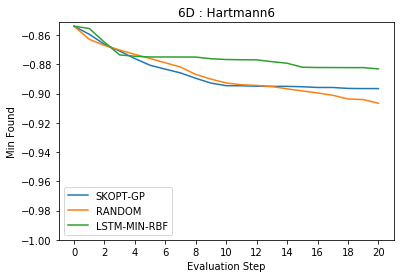

In [246]:
def plot_for_dim_new_version(dim, legend=False):
    data = {}
    
    data['SKOPT']  = utils.average_min_found_values_across_rows(load_data(dim, 'skopt-gp'))
    
#    
    data['RANDOM'] = utils.average_min_found_values_across_rows(load_data(dim, 'random'))
    
    for k in BASELINES:
        label = k
        if k is 'SKOPT':
            label = 'SKOPT-GP'
        
        plt.plot(data[k], label=label)
        
    for kernel in ['rbf']:
        for loss in ['MIN']:
#                 for kernel in ['rbf', 'matern32']:
#         for loss in LOSS_FUNCS:

            y = utils.average_min_found_values_across_rows(load_data(dim, 'lstm-%s-%s' %(loss, kernel)))
            plt.plot(y, label='LSTM-%s-%s'%(loss, kernel.upper()))
    if legend:
        plt.legend()
    xticks = range(0,N_STEPS+1,2)
    plt.ylabel('Min Found')
    plt.xlabel('Evaluation Step')
    plt.xticks(xticks)
    plt.ylim(-1)
    plt.title('%dD : %s' % (dim, FUNCTIONS['name'][dim]) )
    plt.plot()
plot_for_dim_new_version(6, legend=True)

In [249]:
# NOTE: This code is not working
def plot_for_fun(fun, fun_tf, n_runs, dim):
    data = {}
    for i in range(n_runs):
        print("Run ",i+1,"/",n_runs)
        # Shift function = Random Starting point
        x0 = np.random.normal(size=dim, scale=0.2)
        # Flip function
        flip = 1#np.random.choice([-1.0,1.0])
        # Shift up and down
        y0 = np.random.normal(size=1, scale=0.2)
        
        if i==0:
            data['SKOPT']  = [utils.min_up_to_k(get_y_from_skopt(dim, func=lambda x : float(y0+fun(flip*x+x0))))]
            data['RANDOM'] = [utils.min_up_to_k(get_y_from_random(dim, steps = N_STEPS+1,
                                                                  func= lambda x : float(y0+fun(flip*x+x0))))]
            for loss in LOSS_FUNCS:
                data[loss] = [utils.min_up_to_k(get_y_from_lstm('rbf', dim, loss, 
                                                                lambda x : y0+fun_tf(flip*x+x0)))]
        else:
            data['SKOPT']  += [utils.min_up_to_k(get_y_from_skopt(dim, func=lambda x : float(y0+fun(flip*x+x0))))]
            data['RANDOM'] += [utils.min_up_to_k(get_y_from_random(dim, steps = N_STEPS+1,
                                                                  func= lambda x : float(y0+fun(flip*x+x0))))]
            for loss in LOSS_FUNCS:
                data[loss] += [utils.min_up_to_k(get_y_from_lstm('rbf', dim, loss, 
                                                                lambda x : y0+fun_tf(flip*x+x0)))]
        
    return data
        
    
    
def plot_results(data, dim=2):
    for k in data.keys():
        plt.plot(np.mean(np.array(data[k]),axis=0), label=k)
        
    xticks = range(0,N_STEPS+1,2)
    plt.ylabel('Min Found')
    plt.xlabel('Evaluation Step')
    plt.xticks(xticks)
    plt.ylim(-1)
    plt.title('%dD' % dim)
    plt.legend()
    plt.plot()

<function parabolasin at 0x11e4dfea0>
Run  1 / 10


TypeError: get_y_from_skopt() got an unexpected keyword argument 'func'

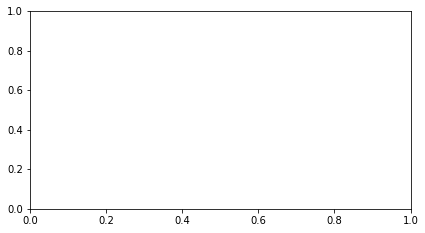

In [254]:
count = 0
plt.figure(figsize=(15,4*2))
for fun, fun_tf, dim in zip([bm.parabolasin, bm.hartmann3, bm.styblinski4, bm.hartmann6],
                           [bm.parabolasin_tf, bm.hartmann3_tf, bm.styblinski4_tf, bm.hartmann6_tf],[2,3,4,6]):
    print(fun)
    plt.subplot(2,2,count + 1 )
    data = plot_for_fun(fun, fun_tf , 10, dim)
    plot_results(data, dim)
    count = count + 1
plt.tight_layout()


In [253]:
import imp
imp.reload(benchmarkfunctions)

<module 'benchmarkfunctions' from '/Users/heytitle/projects/neural-network-project/benchmarkfunctions.py'>

In [225]:
y = load_data(2, 'skopt-gp')

In [228]:
list(y)

[array([-0.99947602, -0.99693319, -0.99902242, -0.92384711, -0.99823548,
        -0.99798753, -0.99840252, -0.99774275, -0.99341528, -0.99805212,
        -0.99872265, -0.99927806, -0.98608427, -0.99896566, -0.99873614,
        -0.99869359, -0.99792666, -0.99632744, -0.99996629, -0.99999226,
        -0.99973324]),
 array([-0.93812654, -0.99150512, -0.9994643 , -0.9983761 , -0.99578417,
        -0.9987611 , -0.98237711, -0.99923151, -0.98813876, -0.94733661,
        -0.99993875, -0.99588822, -0.99816047, -0.98608427, -0.99999156,
        -0.99632744, -0.99940594, -0.99811004, -0.9987945 , -0.99938327,
        -0.9998807 ]),
 array([-0.90801261, -0.99937985, -0.99776546, -0.97741438, -0.9987078 ,
        -0.99881824, -0.9999539 , -0.92992514, -0.99993077, -0.96702686,
        -0.99969997, -0.99588822, -0.99632744, -0.99919332, -0.99847764,
        -0.99825993, -0.98608427, -0.99782254, -0.99991957, -0.99976947,
        -0.99959686]),
 array([-0.97499542, -0.99978779, -0.99857085, -0.99909